In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip INbreast release
!unzip -o "/content/drive/MyDrive/INbreast Release 1.0.zip" -d /content/INbreast_raw


Mounted at /content/drive
Archive:  /content/drive/MyDrive/INbreast Release 1.0.zip
  inflating: /content/INbreast_raw/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20586986_6c613a14b80a8591_MG_L_ML_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587054_b6a4f750c6df4f90_MG_R_CC_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587148_fd746d25eb40b3dc_MG_R_CC_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587200_fd746d25eb40b3dc_MG_R_ML_ANON.dcm  
  inflating: /content/INbreast_raw/AllDICOMs/20587226_fd746d25eb40b3dc_MG_L_ML_ANON.dcm  
  inflating: /co

In [2]:
import os

base_dir = "/content/INbreast_raw"
for root, dirs, files in os.walk(base_dir):
    print(root, len(files), "files")


/content/INbreast_raw 4 files
/content/INbreast_raw/AllROI 343 files
/content/INbreast_raw/PectoralMuscle 0 files
/content/INbreast_raw/PectoralMuscle/Pectoral Muscle XML 201 files
/content/INbreast_raw/PectoralMuscle/Pectoral Muscle ROI 201 files
/content/INbreast_raw/AllXML 343 files
/content/INbreast_raw/AllDICOMs 412 files
/content/INbreast_raw/MedicalReports 117 files


In [3]:
import pandas as pd

csv_path = os.path.join(base_dir, "INbreast.csv")
df_csv = pd.read_csv(csv_path, sep=";")   # semicolon separator

print("CSV Columns:", df_csv.columns.tolist())
print(df_csv.head())


CSV Columns: ['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date', 'File Name', 'ACR', 'Bi-Rads']
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads  
0       1  
1       3  
2       1  
3       3  
4       5  


In [4]:
xls_path = os.path.join(base_dir, "INbreast.xls")
df_xls = pd.read_excel(xls_path)

print("XLS Columns:", df_xls.columns.tolist())
print(df_xls.head())


XLS Columns: ['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date', 'File Name', 'ACR', 'Bi-Rads', 'Mass ', 'Micros', 'Distortion', 'Asymmetry', 'Findings Notes (in Portuguese)', 'Other Notes', 'Lesion Annotation Status', 'Pectoral Muscle Annotation', 'Other Annotations']
  Patient ID Patient age Laterality View  Acquisition date   File Name ACR  \
0    removed     removed          R   CC          201001.0  22678622.0   4   
1    removed     removed          L   CC          201001.0  22678646.0   4   
2    removed     removed          R  MLO          201001.0  22678670.0   4   
3    removed     removed          L  MLO          201001.0  22678694.0   4   
4    removed     removed          R   CC          201001.0  22614074.0   2   

  Bi-Rads Mass  Micros Distortion Asymmetry Findings Notes (in Portuguese)  \
0       1   NaN    NaN        NaN       NaN                         normal   
1       3     X    NaN        NaN       NaN                         nódulo   
2      

In [5]:
!pip install xlrd

In [6]:
# Merge on File Name (the unique DICOM ID)
df = pd.merge(df_csv, df_xls, on="File Name", how="inner")

print("Merged Columns:", df.columns.tolist())
print(df.head())


Merged Columns: ['Patient ID_x', 'Patient age_x', 'Laterality_x', 'View_x', 'Acquisition date_x', 'File Name', 'ACR_x', 'Bi-Rads_x', 'Patient ID_y', 'Patient age_y', 'Laterality_y', 'View_y', 'Acquisition date_y', 'ACR_y', 'Bi-Rads_y', 'Mass ', 'Micros', 'Distortion', 'Asymmetry', 'Findings Notes (in Portuguese)', 'Other Notes', 'Lesion Annotation Status', 'Pectoral Muscle Annotation', 'Other Annotations']
  Patient ID_x Patient age_x Laterality_x View_x  Acquisition date_x  \
0      removed       removed            R     CC              201001   
1      removed       removed            L     CC              201001   
2      removed       removed            R    MLO              201001   
3      removed       removed            L    MLO              201001   
4      removed       removed            R     CC              201001   

   File Name ACR_x Bi-Rads_x Patient ID_y Patient age_y  ... Bi-Rads_y Mass   \
0   22678622     4         1      removed       removed  ...         1   NaN 

In [10]:
df = df_xls.copy()

def classify_birads(birads):
    try:
        b = int(birads)
    except:
        return "Unknown"
    if b <= 2:
        return "Benign"
    elif b == 3:
        return "Suspicious"   # optional group
    elif b >= 4:
        return "Malignant"
    return "Unknown"

df["Pathology"] = df["Bi-Rads"].apply(classify_birads)

print(df[["File Name", "Bi-Rads", "Pathology"]].head(10))

    File Name Bi-Rads   Pathology
0  22678622.0       1      Benign
1  22678646.0       3  Suspicious
2  22678670.0       1      Benign
3  22678694.0       3  Suspicious
4  22614074.0       5   Malignant
5  22614097.0       2      Benign
6  22614127.0       5   Malignant
7  22614150.0       2      Benign
8  50997434.0       2      Benign
9  50997461.0      4a     Unknown


In [12]:
# Create a dictionary mapping file names to full paths
dicom_dir = os.path.join(base_dir, "AllDICOMs")
all_dicoms = {os.path.splitext(f)[0]: os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith(".dcm")}

print(f"Found {len(all_dicoms)} DICOM files.")

Found 410 DICOM files.


In [11]:
# Drop rows with missing File Name
df = df.dropna(subset=["File Name"]).copy()

# Convert to string of integers
df["FileNameStr"] = df["File Name"].astype(int).astype(str)

# Map to dicoms
df["DicomPath"] = df["FileNameStr"].map(all_dicoms)

print(df[["FileNameStr", "Bi-Rads", "Pathology", "DicomPath"]].head(10))

  FileNameStr Bi-Rads   Pathology DicomPath
0    22678622       1      Benign       NaN
1    22678646       3  Suspicious       NaN
2    22678670       1      Benign       NaN
3    22678694       3  Suspicious       NaN
4    22614074       5   Malignant       NaN
5    22614097       2      Benign       NaN
6    22614127       5   Malignant       NaN
7    22614150       2      Benign       NaN
8    50997434       2      Benign       NaN
9    50997461      4a     Unknown       NaN


In [14]:
summary_csv = "/content/inbreast_labels.csv"
df[["FileNameStr", "Patient ID", "Bi-Rads", "Pathology", "DicomPath"]].to_csv(summary_csv, index=False)
print("✅ Saved summary:", summary_csv)

✅ Saved summary: /content/inbreast_labels.csv


In [15]:
import shutil, os

output_base = "/content/INbreast_processed"
malignant_dir = os.path.join(output_base, "Malignant")
benign_dir = os.path.join(output_base, "Benign")
suspicious_dir = os.path.join(output_base, "Suspicious")

os.makedirs(malignant_dir, exist_ok=True)
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(suspicious_dir, exist_ok=True)

for _, row in df.iterrows():
    dicom_path = row["DicomPath"]
    if pd.isna(dicom_path):
        continue

    pathology = row["Pathology"]
    if pathology == "Malignant":
        shutil.copy(dicom_path, malignant_dir)
    elif pathology == "Benign":
        shutil.copy(dicom_path, benign_dir)
    elif pathology == "Suspicious":
        shutil.copy(dicom_path, suspicious_dir)

print("✅ Files copied to folders")


✅ Files copied to folders


In [16]:
import os

dicom_dir = os.path.join(base_dir, "AllDICOMs")

all_dicoms = {}
for f in os.listdir(dicom_dir):
    if f.lower().endswith(".dcm"):
        key = os.path.splitext(f)[0].lstrip("0")  # remove leading zeros
        all_dicoms[key] = os.path.join(dicom_dir, f)

df["DicomPath"] = df["FileNameStr"].map(all_dicoms)
print(df[["FileNameStr", "DicomPath"]].head(10))

  FileNameStr DicomPath
0    22678622       NaN
1    22678646       NaN
2    22678670       NaN
3    22678694       NaN
4    22614074       NaN
5    22614097       NaN
6    22614127       NaN
7    22614150       NaN
8    50997434       NaN
9    50997461       NaN


In [17]:
import os

dicom_dir = os.path.join(base_dir, "AllDICOMs")
dicom_files = sorted(os.listdir(dicom_dir))[:20]  # first 20 files
print(dicom_files[:20])


['20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm', '20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm', '20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm', '20586986_6c613a14b80a8591_MG_L_ML_ANON.dcm', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON.dcm', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON.dcm', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON.dcm', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON.dcm', '20587294_e634830794f5c1bd_MG_R_CC_ANON.dcm', '20587320_e634830794f5c1bd_MG_L_CC_ANON.dcm', '20587346_e634830794f5c1bd_MG_R_ML_ANON.dcm', '20587372_e634830794f5c1bd_MG_L_ML_ANON.dcm', '20587466_d571b5880ad2a016_MG_L_CC_ANON.dcm', '20587492_d571b5880ad2a016_MG_R_ML_ANON.dcm', '20587518_d571b5880ad2a016_MG_L_ML_ANON.dcm', '20587544_d571b5880ad2a016_MG_R_CC_ANON.dcm', '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.dcm', '20587638_f4b2d377f43ba0bd_MG_L_CC_ANON.dcm']


In [18]:
# Build dictionary with multiple keys (raw, stripped, int)
all_dicoms = {}
for f in os.listdir(dicom_dir):
    if f.lower().endswith(".dcm"):
        name = os.path.splitext(f)[0]
        all_dicoms[name] = os.path.join(dicom_dir, f)
        all_dicoms[name.lstrip("0")] = os.path.join(dicom_dir, f)  # remove leading zeros
        all_dicoms[name.replace("IM-","")] = os.path.join(dicom_dir, f)  # if IM- prefix exists

df["DicomPath"] = df["FileNameStr"].map(all_dicoms)

print(df[["FileNameStr", "DicomPath"]].head(20))


   FileNameStr DicomPath
0     22678622       NaN
1     22678646       NaN
2     22678670       NaN
3     22678694       NaN
4     22614074       NaN
5     22614097       NaN
6     22614127       NaN
7     22614150       NaN
8     50997434       NaN
9     50997461       NaN
10    50997488       NaN
11    50997515       NaN
12    24055445       NaN
13    24055464       NaN
14    24055483       NaN
15    24055502       NaN
16    22580192       NaN
17    22580218       NaN
18    22580244       NaN
19    22580270       NaN


In [19]:
import os

dicom_dir = os.path.join(base_dir, "AllDICOMs")

# Dictionary: {numeric_id : full_path}
all_dicoms = {}
for f in os.listdir(dicom_dir):
    if f.lower().endswith(".dcm"):
        prefix = f.split("_")[0]   # take only the number before first "_"
        all_dicoms[prefix] = os.path.join(dicom_dir, f)

print("Sample mapping:", list(all_dicoms.items())[:5])

Sample mapping: [('53581124', '/content/INbreast_raw/AllDICOMs/53581124_3be876aecfaad4ca_MG_L_ML_ANON.dcm'), ('50995872', '/content/INbreast_raw/AllDICOMs/50995872_c94d8a1ebd452afe_MG_L_ML_ANON.dcm'), ('24065860', '/content/INbreast_raw/AllDICOMs/24065860_c01f83a1eb283270_MG_R_ML_ANON.dcm'), ('53587131', '/content/INbreast_raw/AllDICOMs/53587131_7b71aa9928e6975e_MG_L_CC_ANON.dcm'), ('20587174', '/content/INbreast_raw/AllDICOMs/20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm')]


In [20]:
# Convert to string of integers
df["FileNameStr"] = df["File Name"].astype("Int64").astype(str)

# Try to map
df["DicomPath"] = df["FileNameStr"].map(all_dicoms)

print(df[["FileNameStr", "DicomPath"]].head(20))


   FileNameStr                                          DicomPath
0     22678622  /content/INbreast_raw/AllDICOMs/22678622_61b13...
1     22678646  /content/INbreast_raw/AllDICOMs/22678646_61b13...
2     22678670  /content/INbreast_raw/AllDICOMs/22678670_61b13...
3     22678694  /content/INbreast_raw/AllDICOMs/22678694_61b13...
4     22614074  /content/INbreast_raw/AllDICOMs/22614074_6bd24...
5     22614097  /content/INbreast_raw/AllDICOMs/22614097_6bd24...
6     22614127  /content/INbreast_raw/AllDICOMs/22614127_6bd24...
7     22614150  /content/INbreast_raw/AllDICOMs/22614150_6bd24...
8     50997434  /content/INbreast_raw/AllDICOMs/50997434_97ec8...
9     50997461  /content/INbreast_raw/AllDICOMs/50997461_97ec8...
10    50997488  /content/INbreast_raw/AllDICOMs/50997488_97ec8...
11    50997515  /content/INbreast_raw/AllDICOMs/50997515_97ec8...
12    24055445  /content/INbreast_raw/AllDICOMs/24055445_ac318...
13    24055464  /content/INbreast_raw/AllDICOMs/24055464_ac318...
14    2405

In [21]:
matched = df["DicomPath"].notna().sum()
total = len(df)
print(f"Matched {matched}/{total} ({matched/total:.2%})")


Matched 410/410 (100.00%)


In [22]:
import pandas as pd
import os

csv_path = os.path.join(base_dir, "INbreast.csv")
df_csv = pd.read_csv(csv_path, sep=";")

print(df_csv.columns)
print(df_csv.head())

Index(['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date',
       'File Name', 'ACR', 'Bi-Rads'],
      dtype='object')
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads  
0       1  
1       3  
2       1  
3       3  
4       5  


In [23]:
dicom_dir = os.path.join(base_dir, "AllDICOMs")

all_dicoms = {}
for f in os.listdir(dicom_dir):
    if f.lower().endswith(".dcm"):
        prefix = f.split("_")[0]   # take number before first "_"
        all_dicoms[prefix] = os.path.join(dicom_dir, f)


In [24]:
df_csv["FileNameStr"] = df_csv["File Name"].astype(str)
df_csv["DicomPath"] = df_csv["FileNameStr"].map(all_dicoms)

print(df_csv[["File Name", "DicomPath"]].head(20))


    File Name                                          DicomPath
0    22678622  /content/INbreast_raw/AllDICOMs/22678622_61b13...
1    22678646  /content/INbreast_raw/AllDICOMs/22678646_61b13...
2    22678670  /content/INbreast_raw/AllDICOMs/22678670_61b13...
3    22678694  /content/INbreast_raw/AllDICOMs/22678694_61b13...
4    22614074  /content/INbreast_raw/AllDICOMs/22614074_6bd24...
5    22614097  /content/INbreast_raw/AllDICOMs/22614097_6bd24...
6    22614127  /content/INbreast_raw/AllDICOMs/22614127_6bd24...
7    22614150  /content/INbreast_raw/AllDICOMs/22614150_6bd24...
8    50997434  /content/INbreast_raw/AllDICOMs/50997434_97ec8...
9    50997461  /content/INbreast_raw/AllDICOMs/50997461_97ec8...
10   50997488  /content/INbreast_raw/AllDICOMs/50997488_97ec8...
11   50997515  /content/INbreast_raw/AllDICOMs/50997515_97ec8...
12   24055445  /content/INbreast_raw/AllDICOMs/24055445_ac318...
13   24055464  /content/INbreast_raw/AllDICOMs/24055464_ac318...
14   24055483  /content/I

In [25]:
print(df_csv.columns.tolist())


['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date', 'File Name', 'ACR', 'Bi-Rads', 'FileNameStr', 'DicomPath']


In [26]:
print(df_csv.columns.tolist())
print(df_csv.head(5))


['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date', 'File Name', 'ACR', 'Bi-Rads', 'FileNameStr', 'DicomPath']
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads FileNameStr                                          DicomPath  
0       1    22678622  /content/INbreast_raw/AllDICOMs/22678622_61b13...  
1       3    22678646  /content/INbreast_raw/AllDICOMs/22678646_61b13...  
2       1    22678670  /content/INbreast_raw/AllDICOMs/22678670_61b13...  
3       3    22678694  /content/INbreast_raw/AllDICOMs/22678694_61b13...  
4       5    22614074  /content

In [27]:
df_csv["Bi-Rads"] = pd.to_numeric(df_csv["Bi-Rads"], errors="coerce")


In [28]:
import shutil, os

benign_dir = os.path.join(base_dir, "Benign")
malignant_dir = os.path.join(base_dir, "Malignant")
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

benign_count = 0
malignant_count = 0

for _, row in df_csv.iterrows():
    src = row["DicomPath"]
    if pd.isna(src):
        continue

    birads = row["Bi-Rads"]
    if birads in [1, 2, 3]:  # 1–3 = benign / normal
        shutil.copy(src, benign_dir)
        benign_count += 1
    elif birads in [4, 5, 6]:  # 4–6 = suspicious/malignant
        shutil.copy(src, malignant_dir)
        malignant_count += 1

print(f"Benign images copied: {benign_count}")
print(f"Malignant images copied: {malignant_count}")


Benign images copied: 310
Malignant images copied: 57


In [29]:
print("Benign samples:", os.listdir(benign_dir)[:5])
print("Malignant samples:", os.listdir(malignant_dir)[:5])


Benign samples: ['53581124_3be876aecfaad4ca_MG_L_ML_ANON.dcm', '50995872_c94d8a1ebd452afe_MG_L_ML_ANON.dcm', '24065860_c01f83a1eb283270_MG_R_ML_ANON.dcm', '53587131_7b71aa9928e6975e_MG_L_CC_ANON.dcm', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm']
Malignant samples: ['53580858_51bec6477a7898b9_MG_L_CC_ANON.dcm', '22580576_2a5b932da4ce5ca1_MG_L_ML_ANON.dcm', '20587664_f4b2d377f43ba0bd_MG_R_ML_ANON.dcm', '24065707_5291e1aee2bbf5df_MG_R_ML_ANON.dcm', '22613822_45c7f44839fd9e68_MG_R_ML_ANON.dcm']


In [30]:
import os
import pandas as pd
import shutil

# Paths
base_dir = "/content/INbreast_raw"
csv_path = os.path.join(base_dir, "INbreast.csv")
dicom_dir = os.path.join(base_dir, "AllDICOMs")

# Load CSV
df_csv = pd.read_csv(csv_path, sep=";")

# Convert Bi-Rads to numeric
df_csv["Bi-Rads"] = pd.to_numeric(df_csv["Bi-Rads"], errors="coerce")

# Build mapping: prefix number -> DICOM path
all_dicoms = {}
for f in os.listdir(dicom_dir):
    if f.lower().endswith(".dcm"):
        prefix = f.split("_")[0]
        all_dicoms[prefix] = os.path.join(dicom_dir, f)

# Map File Name to DicomPath
df_csv["FileNameStr"] = df_csv["File Name"].astype("Int64").astype(str)
df_csv["DicomPath"] = df_csv["FileNameStr"].map(all_dicoms)

# Output folders
benign_dir = os.path.join(base_dir, "Benign")
malignant_dir = os.path.join(base_dir, "Malignant")
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# Separate based on Bi-Rads
benign_count = 0
malignant_count = 0

for _, row in df_csv.iterrows():
    src = row["DicomPath"]
    if pd.isna(src):
        continue

    birads = row["Bi-Rads"]
    if birads in [1, 2, 3]:   # Benign/normal
        shutil.copy(src, benign_dir)
        benign_count += 1
    elif birads in [4, 5, 6]: # Suspicious/malignant
        shutil.copy(src, malignant_dir)
        malignant_count += 1

print(f"✅ Benign images copied: {benign_count}")
print(f"✅ Malignant images copied: {malignant_count}")


✅ Benign images copied: 310
✅ Malignant images copied: 57


In [31]:
def label_from_birads(b):
    if b in [1,2,3]:
        return "Benign"
    elif b in [4,5,6]:
        return "Malignant"

df_csv["Label"] = df_csv["Bi-Rads"].apply(label_from_birads)

final_csv = os.path.join(base_dir, "inbreast_with_labels.csv")
df_csv.to_csv(final_csv, index=False)
print("✅ CSV saved:", final_csv)


✅ CSV saved: /content/INbreast_raw/inbreast_with_labels.csv


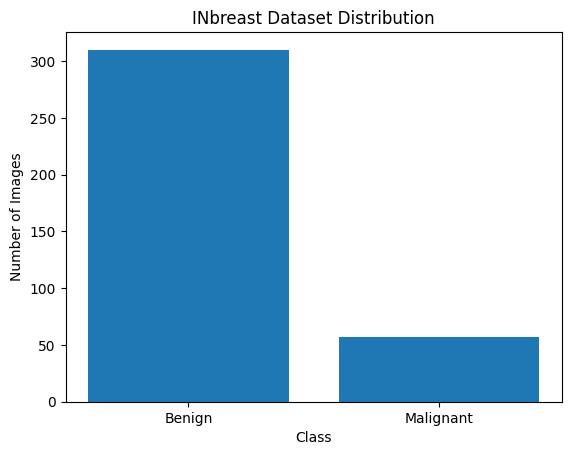

In [32]:
import matplotlib.pyplot as plt

counts = df_csv["Label"].value_counts()
plt.bar(counts.index, counts.values)
plt.title("INbreast Dataset Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [33]:
!pip install albumentations opencv-python-headless pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.1 MB/s eta 0:00:00


In [34]:
import os
import cv2
import albumentations as A
import shutil
import numpy as np


In [35]:
# Safe augmentations for mammograms
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [36]:
def augment_and_balance(src_folder, target_count):
    os.makedirs(src_folder, exist_ok=True)
    files = [f for f in os.listdir(src_folder) if f.endswith(".dcm")]

    current_count = len(files)
    print(f"{os.path.basename(src_folder)}: {current_count} original images")

    # Calculate how many augmentations per image
    n_files = len(files)
    if n_files == 0:
        print("No files found in", src_folder)
        return

    augment_per_image = int(np.ceil((target_count - current_count) / n_files))

    aug_index = 0
    for f in files:
        src_path = os.path.join(src_folder, f)
        ds = pydicom.dcmread(src_path)
        img = ds.pixel_array
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        for i in range(augment_per_image):
            if current_count >= target_count:
                break

            augmented = transform(image=img)["image"]

            out_name = f"aug_{aug_index}_{f}.png"  # save as PNG
            out_path = os.path.join(src_folder, out_name)
            cv2.imwrite(out_path, augmented)

            current_count += 1
            aug_index += 1

    print(f"{os.path.basename(src_folder)}: final count = {current_count}")


In [37]:
benign_dir = os.path.join(base_dir, "Benign")
malignant_dir = os.path.join(base_dir, "Malignant")

benign_count = len([f for f in os.listdir(benign_dir) if f.endswith(".dcm")])
malignant_count = len([f for f in os.listdir(malignant_dir) if f.endswith(".dcm")])

target_count = max(benign_count, malignant_count)
print("Target images per class:", target_count)


Target images per class: 310


In [38]:
import pydicom
augment_and_balance(benign_dir, target_count)
augment_and_balance(malignant_dir, target_count)


Benign: 310 original images
Benign: final count = 310
Malignant: 57 original images
Malignant: final count = 310


In [39]:
def augment_and_balance_dicom(src_folder, target_count):
    import pydicom
    os.makedirs(src_folder, exist_ok=True)
    files = [f for f in os.listdir(src_folder) if f.endswith(".dcm")]

    current_count = len(files)
    print(f"{os.path.basename(src_folder)}: {current_count} original images")

    n_files = len(files)
    if n_files == 0:
        print("No files found in", src_folder)
        return

    augment_per_image = int(np.ceil((target_count - current_count) / n_files))
    aug_index = 0

    for f in files:
        src_path = os.path.join(src_folder, f)
        ds = pydicom.dcmread(src_path)
        img = ds.pixel_array
        img = cv2.normalize(img, None, 0, 65535, cv2.NORM_MINMAX).astype(np.uint16)  # keep 16-bit

        for i in range(augment_per_image):
            if current_count >= target_count:
                break

            augmented = transform(image=img)["image"].astype(np.uint16)

            # Create new DICOM dataset
            new_ds = ds.clone() if hasattr(ds, "clone") else ds.copy()
            new_ds.PixelData = augmented.tobytes()

            out_name = f"aug_{aug_index}_{f}"
            out_path = os.path.join(src_folder, out_name)
            new_ds.save_as(out_path)

            current_count += 1
            aug_index += 1

    print(f"{os.path.basename(src_folder)}: final count = {current_count}")


In [40]:
benign_count = len([f for f in os.listdir(benign_dir) if f.endswith(".dcm")])
malignant_count = len([f for f in os.listdir(malignant_dir) if f.endswith(".dcm")])

target_count = max(benign_count, malignant_count)
print("Target images per class:", target_count)


Target images per class: 310


In [41]:
augment_and_balance_dicom(benign_dir, target_count)
augment_and_balance_dicom(malignant_dir, target_count)


Benign: 310 original images
Benign: final count = 310
Malignant: 57 original images
Malignant: final count = 310


In [42]:
import os

benign_dir = "/content/INbreast_raw/Benign"
malignant_dir = "/content/INbreast_raw/Malignant"

benign_count = len([f for f in os.listdir(benign_dir) if f.endswith(".dcm")])
malignant_count = len([f for f in os.listdir(malignant_dir) if f.endswith(".dcm")])

print("Benign images:", benign_count)
print("Malignant images:", malignant_count)


Benign images: 310
Malignant images: 310


In [43]:
target_count = 1000  # adjust based on GPU memory and dataset size


In [44]:
from sklearn.model_selection import train_test_split

def get_file_list(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".dcm")]

benign_files = get_file_list(benign_dir)
malignant_files = get_file_list(malignant_dir)

files = benign_files + malignant_files
labels = [0]*len(benign_files) + [1]*len(malignant_files)

train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)


In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pydicom

class MammogramDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        ds = pydicom.dcmread(path)
        img = ds.pixel_array
        img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
        img = Image.fromarray(img).convert("RGB")  # InceptionV3 expects 3 channels

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

# Training transforms (on-the-fly augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(299, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# Testing transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

train_dataset = MammogramDataset(train_files, train_labels, transform=train_transform)
test_dataset = MammogramDataset(test_files, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [46]:
!pip install torch torchvision pydicom


In [47]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from PIL import Image
import pydicom
import os
from sklearn.model_selection import train_test_split


In [48]:
class MammogramDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        ds = pydicom.dcmread(path)
        img = ds.pixel_array
        img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
        img = Image.fromarray(img).convert("RGB")  # 3 channels for InceptionV3

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [49]:
def get_file_list(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".dcm")]

benign_dir = "/content/INbreast_raw/Benign"
malignant_dir = "/content/INbreast_raw/Malignant"

benign_files = get_file_list(benign_dir)
malignant_files = get_file_list(malignant_dir)

files = benign_files + malignant_files
labels = [0]*len(benign_files) + [1]*len(malignant_files)

train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)


In [50]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(299, scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

train_dataset = MammogramDataset(train_files, train_labels, transform=train_transform)
test_dataset = MammogramDataset(test_files, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [51]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(299, scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

train_dataset = MammogramDataset(train_files, train_labels, transform=train_transform)
test_dataset = MammogramDataset(test_files, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)  # must init with True

# Disable auxiliary classifier
model.aux_logits = False

# Replace fc with dense layers
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 121MB/s]


In [59]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [60]:
# Define transforms for training & validation
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

# Datasets (replace paths)
train_dataset = datasets.ImageFolder("/content/INbreast_augmented/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder("/content/INbreast_augmented/test", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/INbreast_augmented/train'

In [61]:
import os
import shutil

base_augmented_dir = "/content/INbreast_augmented"
train_dir = os.path.join(base_augmented_dir, "train")
test_dir = os.path.join(base_augmented_dir, "test")

train_benign_dir = os.path.join(train_dir, "Benign")
train_malignant_dir = os.path.join(train_dir, "Malignant")
test_benign_dir = os.path.join(test_dir, "Benign")
test_malignant_dir = os.path.join(test_dir, "Malignant")

# Create directories
os.makedirs(train_benign_dir, exist_ok=True)
os.makedirs(train_malignant_dir, exist_ok=True)
os.makedirs(test_benign_dir, exist_ok=True)
os.makedirs(test_malignant_dir, exist_ok=True)

# Copy files to the new directories
for i, file_path in enumerate(train_files):
    label = train_labels[i]
    if label == 0:
        shutil.copy(file_path, train_benign_dir)
    elif label == 1:
        shutil.copy(file_path, train_malignant_dir)

for i, file_path in enumerate(test_files):
    label = test_labels[i]
    if label == 0:
        shutil.copy(file_path, test_benign_dir)
    elif label == 1:
        shutil.copy(file_path, test_malignant_dir)

print("✅ Data successfully organized into train/test directories.")

✅ Data successfully organized into train/test directories.


In [63]:
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split # Import necessary for train/test_split

# Need to redefine get_file_list, train_files, test_files, train_labels, test_labels
# as they are not in the current cell scope.
def get_file_list(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".dcm")]

benign_dir = "/content/INbreast_raw/Benign"
malignant_dir = "/content/INbreast_raw/Malignant"

benign_files = get_file_list(benign_dir)
malignant_files = get_file_list(malignant_dir)

files = benign_files + malignant_files
labels = [0]*len(benign_files) + [1]*len(malignant_files)

train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)


# ---- Transformations ----
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),        # InceptionV3 input size
    transforms.RandomRotation(20),        # Random rotation
    transforms.RandomHorizontalFlip(),    # Only horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ---- Load Dataset using custom MammogramDataset ----
# Ensure MammogramDataset class is defined in a previous cell and accessible
train_dataset = MammogramDataset(train_files, train_labels, transform=train_transforms)
test_dataset  = MammogramDataset(test_files, test_labels, transform=test_transforms)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [64]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3, Inception_V3_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained InceptionV3
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)
model.aux_logits = False  # disable auxiliary classifier

# Replace FC with custom dense layers
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.Linear(128, 2)  # 2 classes
)

model = model.to(device)


In [65]:
import torch.optim as optim
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 1000
patience = 15
best_val_loss = float("inf")
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())


In [66]:
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / total

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader.dataset)
    val_acc = 100. * correct / total

    # ---- Print progress ----
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # ---- Scheduler step ----
    scheduler.step(val_loss)

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_inceptionv3.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Training complete. Best Val Loss:", best_val_loss)


Epoch [1/1000] Train Loss: 0.7312 | Train Acc: 56.85% Val Loss: 0.6676 | Val Acc: 62.10%
Epoch [2/1000] Train Loss: 0.6259 | Train Acc: 63.51% Val Loss: 0.6111 | Val Acc: 61.29%
Epoch [3/1000] Train Loss: 0.6081 | Train Acc: 66.33% Val Loss: 0.6135 | Val Acc: 62.90%
Epoch [4/1000] Train Loss: 0.5774 | Train Acc: 67.94% Val Loss: 0.5863 | Val Acc: 69.35%
Epoch [5/1000] Train Loss: 0.5477 | Train Acc: 73.39% Val Loss: 0.5590 | Val Acc: 71.77%
Epoch [6/1000] Train Loss: 0.5016 | Train Acc: 76.61% Val Loss: 0.5098 | Val Acc: 75.81%
Epoch [7/1000] Train Loss: 0.4707 | Train Acc: 78.02% Val Loss: 0.3683 | Val Acc: 83.87%
Epoch [8/1000] Train Loss: 0.4312 | Train Acc: 82.06% Val Loss: 0.3380 | Val Acc: 83.87%
Epoch [9/1000] Train Loss: 0.3381 | Train Acc: 85.28% Val Loss: 0.2808 | Val Acc: 88.71%
Epoch [10/1000] Train Loss: 0.3267 | Train Acc: 86.29% Val Loss: 0.2106 | Val Acc: 91.94%
Epoch [11/1000] Train Loss: 0.2677 | Train Acc: 89.31% Val Loss: 0.2568 | Val Acc: 89.52%
Epoch [12/1000] Tra

Confusion Matrix:
 [[61  1]
 [ 2 60]]
F1 Score: 0.975609756097561
Sensitivity (Recall) for Malignant class: 0.967741935483871
ROC AUC: 0.9989594172736733


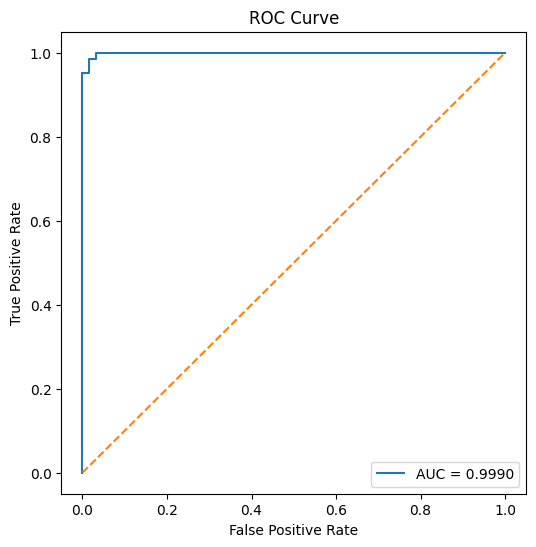

In [67]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_labels = []
all_probs = []
all_preds = []

# Forward pass
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())  # probability of class 1 (malignant)
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# ---- F1 Score ----
f1 = f1_score(all_labels, all_preds)
print("F1 Score:", f1)

# ---- Sensitivity / Recall for malignant class (class 1) ----
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (Recall) for Malignant class:", sensitivity)

# ---- ROC Curve & AUC ----
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)
print("ROC AUC:", auc_score)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


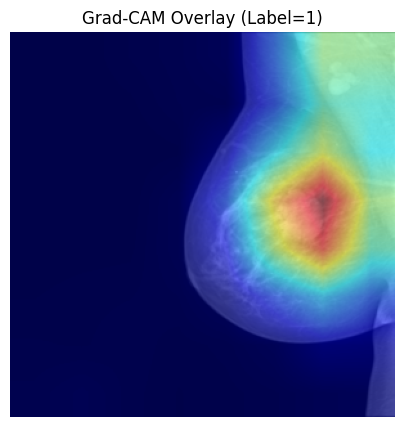

In [68]:
from torchvision import models
import cv2

# Grad-CAM hook
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_img, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_img)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        loss = output[:, class_idx]
        loss.backward(retain_graph=True)

        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(input_img.size(2), input_img.size(3)), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Usage example for one test image
sample_img, label = test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

grad_cam = GradCAM(model, target_layer=model.Mixed_7c)  # final inception block
cam_mask = grad_cam.generate_cam(input_tensor)

# Overlay CAM on original image
img_np = sample_img.permute(1,2,0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

heatmap = cv2.applyColorMap(np.uint8(255*cam_mask), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = 0.5*img_np + 0.5*(heatmap/255)

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.title(f"Grad-CAM Overlay (Label={label})")
plt.axis("off")
plt.show()
